This project was inspired by stratascratch's data project: https://platform.stratascratch.com/data-projects/delivery-duration-prediction

The dataset contains orders during 2015 from DoorDash, which is a U.S. online food delivery and ordering company.

The aim of this project is to:

- Clean the data

- Explore and summarize the data to provide insights into the company operations

- Build a model to predict the estimated delivery duration

# 0. Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
#py -m pip install pingouin
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
plt.style.use('default')

# 1. Data loading

In [3]:
df = pd.read_csv('historical_data.csv')
df.index.name ='order_id'
df.reset_index(inplace=True)
df.order_id = df.order_id.astype('int64')
#df.market_id = df.market_id.astype('int64')

# 2. Data cleaning

## 2.1. Features

In [4]:
print('There are', df.shape[0], 'deliveries to be studied with', df.shape[1], 'columns in the dataset.')

There are 197428 deliveries to be studied with 17 columns in the dataset.


In [5]:
df.head()

,order_id,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


| Feature | Description | Type |
|---|---|---|
| order_id | unique identifier fo each delivery order  | id |
| market_id | unique identifier for each city | id |
| created_at | timestamp in UTC when the order was submitted | date |
| actual_delivery_time | timestamp in UTC when the order was delivered to the consumer | date |
| store_id | unique identifier representing the restaurant the order was submitted for | id |
| store_primary_category | primary cuisine category of the restaurant | nominal |
| order_protocol | identifier denoting the protocol based on the mode the order was received | id |
| total_items | total number of items in the order | discrete |
| subtotal | total value of the order submitted (in cents) | continuous |
| num_distinct_items | number of distinct items included in the order | discrete |
| min_item_price | price of the item with the least cost in the order (in cents) | continuous |
| max_item_price | price of the item with the highest cost in the order (in cents) | continuous |
| total_onshift_dashers | number of available dashers who are within 10 miles of the store at the time of order creation | discrete |
| total_busy_dashers | subset of the above who are currently working on an order | discrete |
| total_outstanding_orders | number of orders within 10 miles of this order that are currently being processed | discrete |
| estimated_order_place_duration | estimated time for the restaurant to receive the order from DoorDash (in seconds) | continuous |
| total_busy_dashers | estimated travel time between store and consumer (in seconds) | continuous |

## 2.2. Data types

In [6]:
df.dtypes

order_id                                          int64
market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

### Date format convertion

The columns created_at and actual_delivery_time must be in a date format.

In [7]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

Plus, I'm going to transform the 2 date attributes into 2 numerical variables: hour (of order creation), delivery_duration

## 2.3. Data transformation - creation of new variables

### Delivery duration

For this study I want to know the **total delivery duration** of an order, which can be calculated from the difference between "created_at" and "actual_delivery_time".

In [8]:
# First, initialize the new variable
df['delivery_duration'] = ""

# Then, calculate the time difference
df['delivery_duration'] = df['actual_delivery_time'] - df['created_at']
df['delivery_duration'] = df['delivery_duration'].dt.total_seconds()

### Date and time features

A lot of information can be extracted from the feature "created_at". I can create the following features:

- Year, Month, Day

- Day of the week

- Hour of the day

#### Year

In [9]:
df['created_at'].dt.year.value_counts()

created_at
2015    197427
2014         1
Name: count, dtype: int64

All the data is from 2015 but one. It will be removed since I want to analize 2015 data.

In [10]:
df = df.loc[df['created_at'].dt.year == 2015,].copy()

#### Month

In [11]:
df['month'] = df['created_at'].dt.month
df['month'].value_counts()

month
2    128945
1     68482
Name: count, dtype: int64

There is only data from January and February.

#### Day

In [12]:
df['day'] = df['created_at'].dt.day
df['day'].value_counts()

day
7     9149
15    9087
14    9016
8     8874
24    8230
31    8146
25    7934
16    7932
1     7724
13    7383
9     7278
6     7118
5     6850
12    6784
30    6763
2     6715
23    6611
11    6403
3     6369
4     6113
10    6091
17    6078
29    6038
22    6001
28    5669
27    5524
26    5478
18    3981
21    2088
Name: count, dtype: int64

It's strange that days 19 and 20 have no data.

#### Weekday

In [13]:
df['weekday'] = df['created_at'].dt.day_of_week
df['weekday'].value_counts()

weekday
5    34541
6    33619
4    27875
0    27403
3    25673
2    24254
1    24062
Name: count, dtype: int64

#### Hour

In [14]:
df['hour'] = df['created_at'].dt.hour
df['hour'].value_counts()

hour
2     36976
1     28190
3     27068
20    15560
4     15250
19    13541
0     12669
21    11465
22     8821
23     8163
5      7095
18     5100
17     3413
16     2109
6      1416
15      538
14       40
7        11
8         2
Name: count, dtype: int64

There's no data from 9 to 13 h.

#### Date

In [15]:
df['date'] = df['created_at'].dt.date

### Busy dashers ratio

'total_onshift_dashers' contains the number of working dashers and 'total_busy_dashers' the number of busy workers. By calculating the difference, I can obtain the number of available dashers.

In [16]:
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']

## 2.4. Initial exploration

### Numerical variables

In [17]:
num_columns = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 
               'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'busy_dashers_ratio', 
               'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'delivery_duration']
df[num_columns].describe()

c:\Users\Roger\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,busy_dashers_ratio,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration
count,197427.000000,197427.000000,197427.000000,197427.000000,197427.000000,181166.000000,181166.000000,181166.000000,1.775900e+05,197427.000000,196901.000000,197420.000000
mean,3.196402,2682.336403,2.670800,686.213866,1159.586424,44.808093,41.739747,58.050065,NaN,308.559483,545.359612,2865.131294
std,2.666548,1823.096951,1.630255,522.035963,558.411931,34.526783,32.145733,52.661830,NaN,90.139351,219.353253,1613.285907
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,-inf,0.000000,0.000000,101.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,8.269231e-01,251.000000,382.000000,2104.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,9.622642e-01,251.000000,544.000000,2660.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,1.000000e+00,446.000000,702.000000,3381.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,inf,2715.000000,2088.000000,373879.000000


The average amount of items per order is 3.20, with a minimum of 1 and a maximum of 411. **Is the maximum an error or an outlier?**

The average subtotal is $26.82. **How is it possible for a subtotal to be 0?**

The average number of distinct items is 2.67.

The average price of the item with least cost is $6.86. **There seem to be a negative price in the data. It has to be analyzed.**

The average price of the item with highest cost is $11.60. **A maximum of 0 is possible?**

The average number of onshift dashers is 44.81. **Does a negative number of onshift dashers make sense?**

The average number of busy dashers is 41.74. **Does a negative number of busy dashers make sense?**

The average number of orders being processed simmultanously is 58.05. **A negative amount of orders being processed is possible?**

The average estimated time for a restaurant to receive an order is 308.56 seconds (5 minutes and 9 seconds).

The average estimated travel time is 545.36 seconds (9 minutes and 5 seconds).

The average delivery duration is 2908.26 seconds (48 minutes and 28 seconds). **A delivery duration of over 3 days is possible?**

### Categorical variables

In [18]:
df.market_id.value_counts()

market_id
2.0    55058
4.0    47599
1.0    38036
3.0    23297
5.0    18000
6.0    14450
Name: count, dtype: int64

There are 6 different markets, each corresponding to a city or region in the U.S.

In [19]:
df.store_id.value_counts()

store_id
6865    937
1311    863
314     815
1686    765
3937    721
       ... 
1258      1
974       1
4260      1
6426      1
1845      1
Name: count, Length: 6743, dtype: int64

There are 6743 DoorDash partner restaurants.

In [20]:
df.store_primary_category.value_counts()

store_primary_category
american             19399
pizza                17321
mexican              17099
burger               10958
sandwich             10060
                     ...  
lebanese                 9
belgian                  2
indonesian               2
chocolate                1
alcohol-plus-food        1
Name: count, Length: 74, dtype: int64

There are 74 different categories of restaurants.

In [21]:
df.order_protocol.value_counts()

order_protocol
1.0    54724
3.0    53199
5.0    44290
2.0    24052
4.0    19354
6.0      794
7.0       19
Name: count, dtype: int64

There are 7 different protocols for the orders. I won't analyze this feature because I don't have information about these protocols.

## 2.5. Outlier detection

### Delivery duration

Issue: there are delivery durations of over a day in the data.

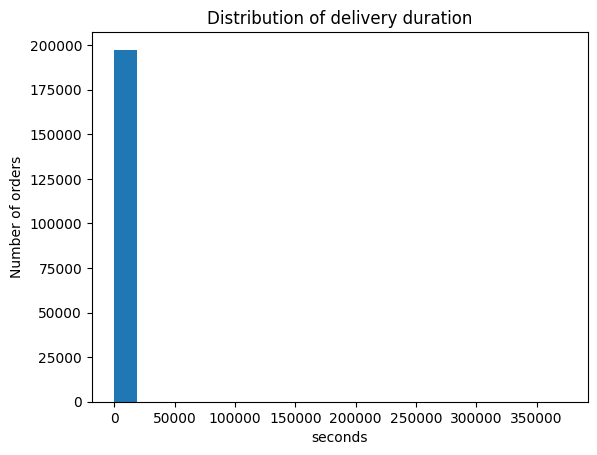

In [22]:
plt.hist(df.delivery_duration, bins = 20)
plt.title('Distribution of delivery duration')
plt.ylabel('Number of orders')
plt.xlabel('seconds')
plt.show()

There is a very high that is most likely an error.

In [23]:
df.sort_values('delivery_duration', ascending = False).head()

,order_id,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,month,day,weekday,hour,date,busy_dashers_ratio
185550,185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,dessert,5.0,3,1520,3,...,0.0,251,476.0,373879.0,1,28,2,8,2015-01-28,NaN
27189,27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,indian,3.0,4,4980,4,...,104.0,251,767.0,332482.0,2,16,0,2,2015-02-16,0.944444
83055,83055,2.0,2015-02-01 02:18:07,2015-02-01 18:08:39,355,burger,4.0,3,2379,2,...,163.0,251,602.0,57032.0,2,1,6,2,2015-02-01,0.935780
190860,190860,1.0,2015-02-16 02:31:05,2015-02-16 17:38:32,2169,indian,3.0,4,3660,4,...,111.0,251,326.0,54447.0,2,16,0,2,2015-02-16,0.985915
86952,86952,3.0,2015-02-05 02:11:40,2015-02-05 15:34:38,1764,thai,2.0,3,2185,3,...,16.0,251,787.0,48178.0,2,5,3,2,2015-02-05,1.000000


There are a two orders with a delivery duration of over 300.000 seconds (over 80 hours / 3 days). They must be errors and will be eliminated from the dataset.

In [24]:
df = df.loc[df['delivery_duration'] < 300000,] # deleting 2 rows

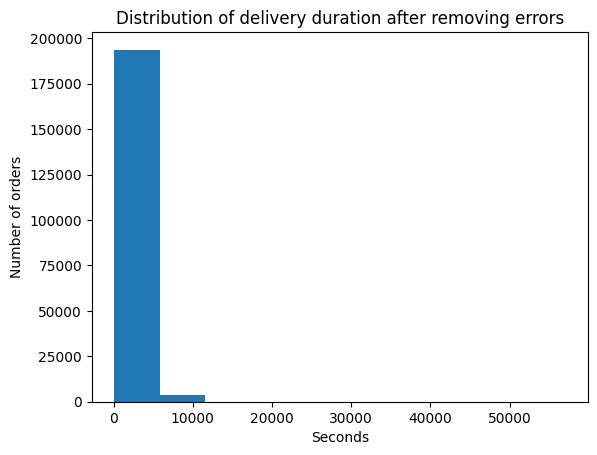

In [25]:
plt.hist(df.delivery_duration)
plt.title('Distribution of delivery duration after removing errors')
plt.ylabel('Number of orders')
plt.xlabel('Seconds')
plt.show()

In [26]:
df.sort_values('delivery_duration', ascending = False).head()

,order_id,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,month,day,weekday,hour,date,busy_dashers_ratio
83055,83055,2.0,2015-02-01 02:18:07,2015-02-01 18:08:39,355,burger,4.0,3,2379,2,...,163.0,251,602.0,57032.0,2,1,6,2,2015-02-01,0.935780
190860,190860,1.0,2015-02-16 02:31:05,2015-02-16 17:38:32,2169,indian,3.0,4,3660,4,...,111.0,251,326.0,54447.0,2,16,0,2,2015-02-16,0.985915
86952,86952,3.0,2015-02-05 02:11:40,2015-02-05 15:34:38,1764,thai,2.0,3,2185,3,...,16.0,251,787.0,48178.0,2,5,3,2,2015-02-05,1.000000
76743,76743,2.0,2015-02-15 04:17:35,2015-02-15 16:59:00,3247,pizza,6.0,1,990,1,...,184.0,446,540.0,45685.0,2,15,6,4,2015-02-15,0.982456
105825,105825,2.0,2015-02-08 04:07:51,2015-02-08 15:03:43,3305,alcohol,5.0,3,2850,3,...,156.0,251,315.0,39352.0,2,8,6,4,2015-02-08,1.072917


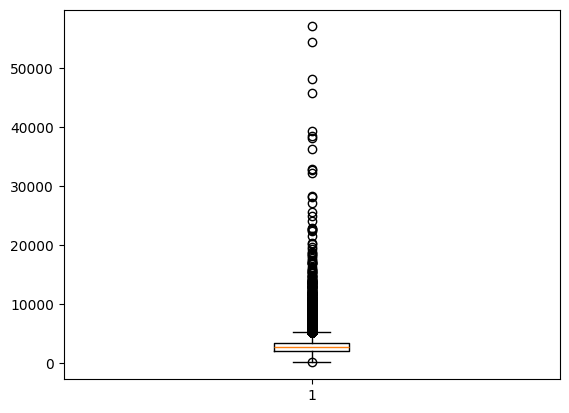

In [27]:
plt.boxplot(df['delivery_duration'])
plt.show()

In [28]:
df['delivery_duration'].describe()

count    197418.000000
mean       2861.582323
std        1164.087414
min         101.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       57032.000000
Name: delivery_duration, dtype: float64

The following delivery durations are around 55.000 seconds (over 15 h) which is within a day time but it is still a very long delivery time.This data may not be an error since a restaurant can remain open for 15 straight hours

#### Delete this part ???

I will remove the orders that are 1.5 times IQR greater than 3rd quantile or 1.5 times IQR lower than the 1st quantile.

In [29]:
# IQR for removing outliers
delivery_1st_quantile = np.quantile(df['delivery_duration'], 0.25)
delivery_3rd_quantile = np.quantile(df['delivery_duration'], 0.75)
IQR = delivery_3rd_quantile - delivery_1st_quantile
delivery_average = df['delivery_duration'].mean()

upper_bound = delivery_3rd_quantile + (1.5 * IQR)
lower_bound = delivery_1st_quantile - (1.5 * IQR)

print('Upper bound:', upper_bound, '\nLower bound:', lower_bound)

#df = df.loc[(df['delivery_duration'] <= upper_bound) & (df['delivery_duration'] >= lower_bound) , ]

Upper bound: 5296.5 
Lower bound: 188.5


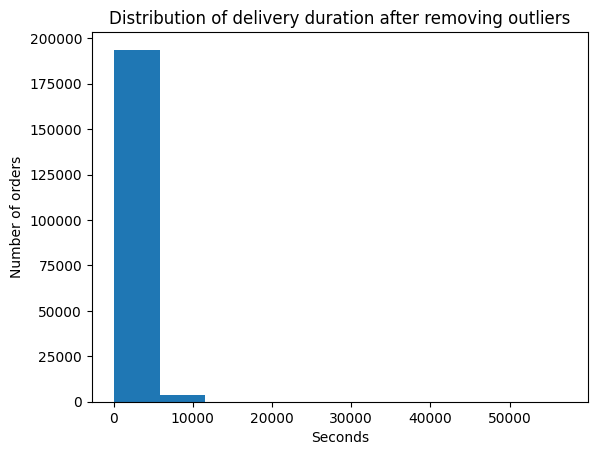

In [30]:
plt.hist(df.delivery_duration)
plt.title('Distribution of delivery duration after removing outliers')
plt.ylabel('Number of orders')
plt.xlabel('Seconds')
plt.show()

In [31]:
df.sort_values('delivery_duration', ascending = False).head()

,order_id,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,month,day,weekday,hour,date,busy_dashers_ratio
83055,83055,2.0,2015-02-01 02:18:07,2015-02-01 18:08:39,355,burger,4.0,3,2379,2,...,163.0,251,602.0,57032.0,2,1,6,2,2015-02-01,0.935780
190860,190860,1.0,2015-02-16 02:31:05,2015-02-16 17:38:32,2169,indian,3.0,4,3660,4,...,111.0,251,326.0,54447.0,2,16,0,2,2015-02-16,0.985915
86952,86952,3.0,2015-02-05 02:11:40,2015-02-05 15:34:38,1764,thai,2.0,3,2185,3,...,16.0,251,787.0,48178.0,2,5,3,2,2015-02-05,1.000000
76743,76743,2.0,2015-02-15 04:17:35,2015-02-15 16:59:00,3247,pizza,6.0,1,990,1,...,184.0,446,540.0,45685.0,2,15,6,4,2015-02-15,0.982456
105825,105825,2.0,2015-02-08 04:07:51,2015-02-08 15:03:43,3305,alcohol,5.0,3,2850,3,...,156.0,251,315.0,39352.0,2,8,6,4,2015-02-08,1.072917


In [32]:
df['delivery_duration'].describe()

count    197418.000000
mean       2861.582323
std        1164.087414
min         101.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       57032.000000
Name: delivery_duration, dtype: float64

Now the value seem more reasonable. The maximum delivery duration is around 1.47 hours, while the average delivery takes about 45 minutes.

The distribution is skewed (asymetric) towards the right. 

Conclusions:

- It is more common that the delivery duration is above the median than below it. 

- It is harder to deliver faster than taking longer. Many things can happen to slow down the delivery: delay on the kitchen, traffic on the road...

### Total items

Issue: there is an order with a number of items greater than 400.

In [33]:
df['total_items'].describe()

count    197418.000000
mean          3.196375
std           2.666567
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         411.000000
Name: total_items, dtype: float64

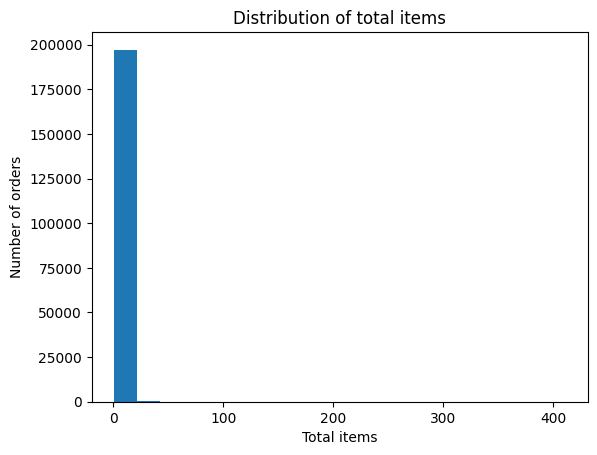

In [34]:
plt.hist(df['total_items'], bins = 20)
plt.title('Distribution of total items')
plt.ylabel('Number of orders')
plt.xlabel('Total items')
plt.show()

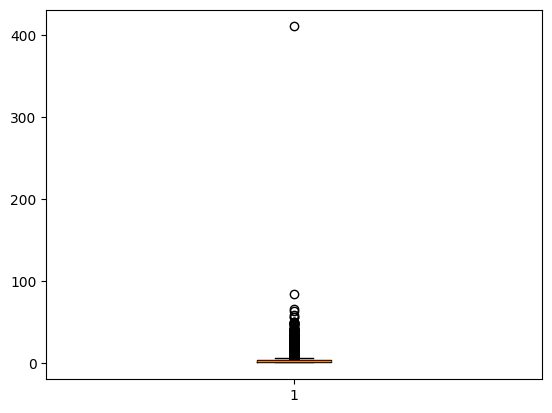

In [35]:
plt.boxplot(df['total_items'])
plt.show()

In [36]:
df.sort_values('total_items', ascending = False).head()

,order_id,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration,month,day,weekday,hour,date,busy_dashers_ratio
47231,47231,2.0,2015-02-06 00:42:39,2015-02-06 01:33:34,777,fast,4.0,411,3115,5,...,39.0,251,573.0,3055.0,2,6,4,0,2015-02-06,1.000000
182223,182223,6.0,2015-02-15 19:39:32,2015-02-15 20:54:10,1862,fast,4.0,84,1016,4,...,NaN,251,581.0,4478.0,2,15,6,19,2015-02-15,NaN
182800,182800,2.0,2015-02-18 05:42:03,2015-02-18 06:11:25,6931,fast,4.0,66,1634,6,...,32.0,251,389.0,1762.0,2,18,2,5,2015-02-18,0.933333
182796,182796,2.0,2015-02-17 05:45:05,2015-02-17 06:14:01,6931,fast,4.0,64,1166,4,...,21.0,251,389.0,1736.0,2,17,1,5,2015-02-17,0.678571
75577,75577,1.0,2015-01-23 04:33:00,2015-01-23 05:07:45,933,fast,4.0,59,2911,3,...,20.0,251,470.0,2085.0,1,23,4,4,2015-01-23,0.760000


Is it possible to prepare and deliver 411 items in just 50 minutes? I will consider this order an error and delete it.

In [37]:
df = df.loc[df['total_items'] < 400,]

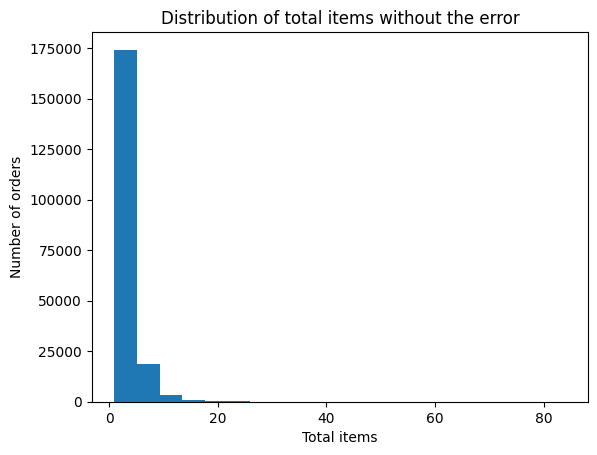

In [38]:
plt.hist(df['total_items'], bins = 20)
plt.title('Distribution of total items without the error')
plt.ylabel('Number of orders')
plt.xlabel('Total items')
plt.show()

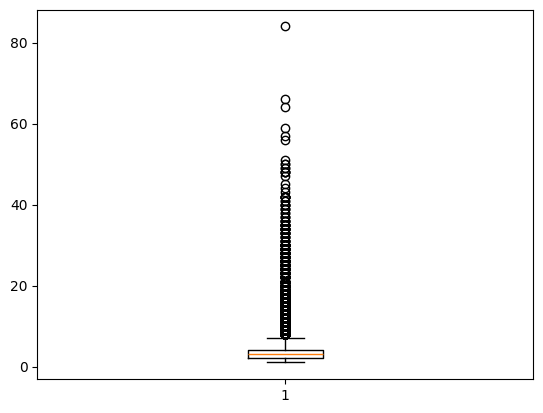

In [39]:
plt.boxplot(df['total_items'])
plt.show()

### Subtotal

Issue: there are orders with a subtotal of 0.

In [40]:
df['subtotal'].describe()

count    197417.000000
mean       2682.323437
std        1823.113901
min           0.000000
25%        1400.000000
50%        2200.000000
75%        3395.000000
max       27100.000000
Name: subtotal, dtype: float64

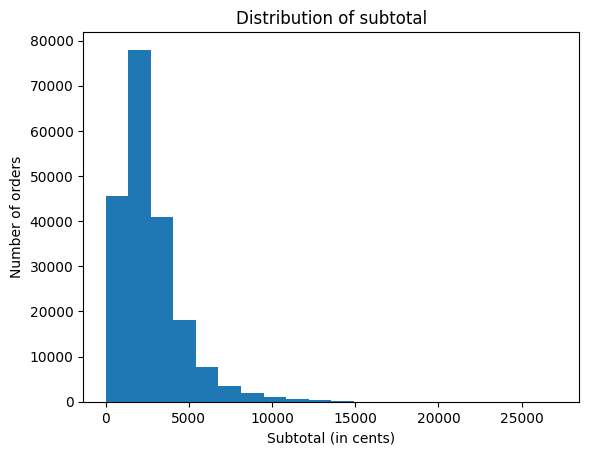

In [41]:
plt.hist(df['subtotal'], bins = 20)
plt.title('Distribution of subtotal')
plt.ylabel('Number of orders')
plt.xlabel('Subtotal (in cents)')
plt.show()

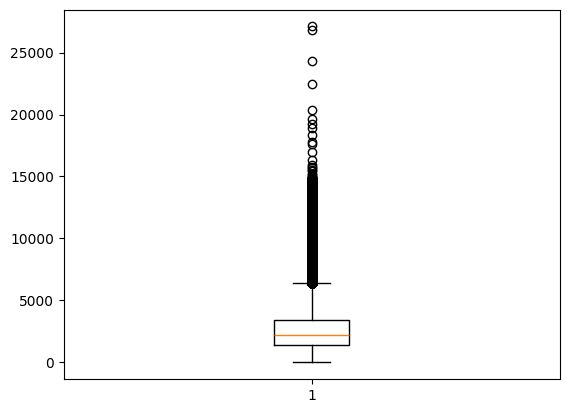

In [42]:
plt.boxplot(df['subtotal'])
plt.show()

In [43]:
df[df['subtotal'] == 0].shape[0]

179

There are 179 orders with a subtotal of 0.

Possible solutions:

- Delete these 179 orders.

- Input the subtotal with a value that makes sense (based on total_items?).

In [44]:
median_per_items = df.groupby('total_items')['subtotal'].median()

def impute_subtotal(row):
    if row['subtotal'] == 0:
        items = row['total_items']
        if items in median_per_items:
            return median_per_items[items]
        else:
            return df['subtotal'].median()
    return row['subtotal']

df['subtotal'] = df.apply(impute_subtotal, axis=1)


In [45]:
df['subtotal'].describe()

count    197417.000000
mean       2684.612906
std        1821.654744
min          12.000000
25%        1402.000000
50%        2200.000000
75%        3396.000000
max       27100.000000
Name: subtotal, dtype: float64

Now, the minimum subtotal is $0.12.

### Min item price

Issue: there are values of min_item_price that are negative.

In [46]:
df['min_item_price'].describe()

count    197417.000000
mean        686.224266
std         522.041541
min         -86.000000
25%         299.000000
50%         595.000000
75%         949.000000
max       14700.000000
Name: min_item_price, dtype: float64

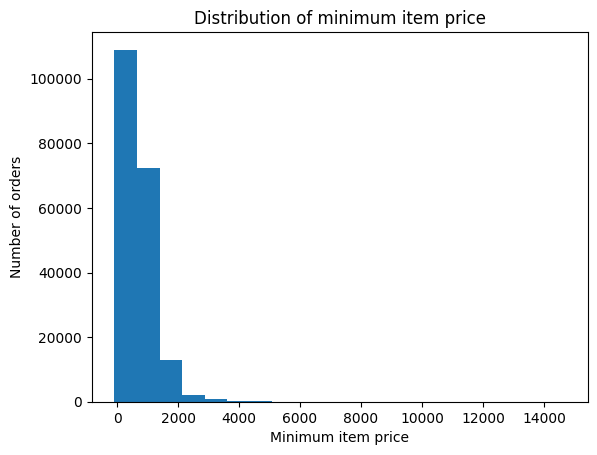

In [47]:
plt.hist(df['min_item_price'], bins = 20)
plt.title('Distribution of minimum item price')
plt.ylabel('Number of orders')
plt.xlabel('Minimum item price')
plt.show()

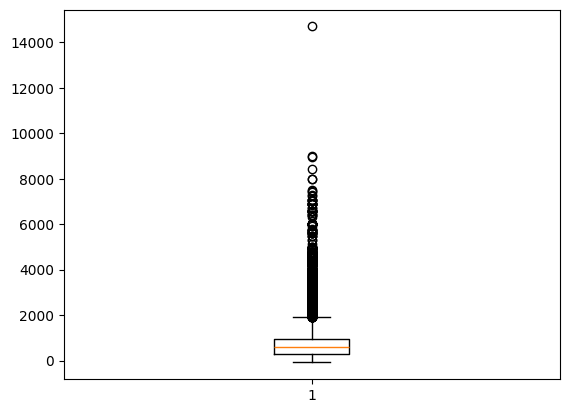

In [48]:
plt.boxplot(df['min_item_price'])
plt.show()

Apart from the negative values, there seems to exist an outlier with a too high value.

In [49]:
df.loc[df['min_item_price'] < 0, ['total_items', 'min_item_price', 'max_item_price', 'subtotal', 'num_distinct_items']].sort_values('min_item_price')

,total_items,min_item_price,max_item_price,subtotal,num_distinct_items
790,3,-86,1066,1003.0,3
187278,16,-52,397,2162.0,5
170424,3,-51,804,951.0,2
46378,15,-48,433,1822.0,4
46369,25,-35,514,1636.0,5
77238,1,-31,52,3099.0,1
104173,7,-30,1211,6095.0,7
91319,16,-13,194,1601.0,5
182207,27,-13,351,2946.0,7
119785,10,-9,594,1938.0,8


The reason negative minimum item prices exist is because of discounts, because the max_item_price is often.

There is also a case where the total items is 1 and the minimum item price is different than the maximum item price, and at the same time, they are different from the subtotal.

In [50]:
df.loc[(df['total_items'] == 1) & (df['min_item_price'] != df['subtotal']), 
       ['total_items', 'min_item_price', 'max_item_price', 'subtotal', 'num_distinct_items']]

,total_items,min_item_price,max_item_price,subtotal,num_distinct_items
1,1,1400,1400,1900.0,1
35,1,825,825,1220.0,1
40,1,825,825,1220.0,1
87,1,799,799,978.0,1
93,1,975,975,1125.0,1
...,...,...,...,...,...
197409,1,639,639,719.0,1
197410,1,497,448,437.0,1
197412,1,345,345,674.0,1
197419,1,729,729,809.0,1


Why are there 16684 orders with a minimum and maximum item price different than the subtotal when the total items is 1? 

It is most likely due to the noise added by the dataset manager to protect confidential information.

Solution: I won't use the min_item_price nor the max_item_price column.

In [51]:
df.drop(columns = ['min_item_price', 'max_item_price'], inplace = True)

### Total onshift dashers

Issue: in some rows there are a negative number of total_onshift_dashers.

It has to be an error or the result of adding noise to the data.

In [52]:
df.loc[df['total_onshift_dashers'] < 0,].shape[0]

21

There are 21 rows with a negative total_onshift_dashers. I will change these values for zeros.

In [53]:
df.loc[df['total_onshift_dashers'] < 0,'total_onshift_dashers'] = 0

### Total busy dashers

Issue: there are negative values of total_busy_dashers. Also, the number of busy dashers can't be greater than the number of working dashers.

In [54]:
df.loc[df['total_busy_dashers'] < 0,].shape[0]

21

There are also 21 rows with negative values of this field.

In [55]:
df.loc[df['total_busy_dashers'] < 0,'total_busy_dashers'] = 0

In [56]:
df.loc[df['total_busy_dashers'] > df['total_onshift_dashers'], ['total_busy_dashers', 'total_onshift_dashers']].shape[0]

40392

40392 orders have a number of busy dashers greater than working dashers. These have to be an error due to generating noise on the data. I will limit the number of busy dashers to the number of working dashers.

In [57]:
df['total_busy_dashers'] = df[['total_onshift_dashers', 'total_busy_dashers']].min(axis = 1)

### Total outstanding orders

Issue: there are negative values of total_outstanding_orders.

In [58]:
df.loc[df['total_outstanding_orders'] < 0,].shape[0]

44

There are 44 negative values of total_outstanding_orders.

In [59]:
df.loc[df['total_outstanding_orders'] < 0,'total_outstanding_orders'] = 0

### Busy dashers ratio

Issue: there are infinite values because it was creating with a division which sometimes had a 0 in the denominator.

In [60]:
df['busy_dashers_ratio'].describe()

c:\Users\Roger\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775810e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

Since there are negative values, due to having a number of busy dashers greater than onshift dashers at the time the column was calculated, I will recalculate this column.

In [61]:
df['busy_dashers_ratio'] = df['total_busy_dashers'] / df['total_onshift_dashers']

## 2.6. Dealing with missing values

In [62]:
df.isna().sum()

order_id                                            0
market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
total_onshift_dashers                           16261
total_busy_dashers                              16261
total_outstanding_orders                        16261
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_duration                                   0
month                                               0
day                                                 0
weekday                     

### Market id

In [63]:
df['market_id'].isna().sum()

987

##### Stores without a market_id

If an order has a store_id but no market_id, the market_id can be obtained from other orders made for that same restaurant.

In [64]:
df.market_id.value_counts()

market_id
2.0    55054
4.0    47596
1.0    38035
3.0    23296
5.0    17999
6.0    14450
Name: count, dtype: int64

In [65]:
df_marktcount = df.groupby('store_id')['market_id'].count().reset_index().rename({'market_id' : 'market_exists_count'}, axis = 1)
print('Number of stores without market_id:', df_marktcount.query('market_exists_count == 0').shape[0])
print('Number of orders from stores without market_id:', df[df['store_id'].isin(df_marktcount.query('market_exists_count == 0').store_id)].shape[0])


Number of stores without market_id: 3
Number of orders from stores without market_id: 3


For these 3 stores there is no way to know the market_id. Since they are just 3, I will remove them.

In [66]:
df = df[df['store_id'].isin(df_marktcount.query('market_exists_count > 0').store_id)]

##### Stores with market_id in other orders

In [67]:
df_markt = df.groupby(['store_id', 'market_id'])['order_id'].count().reset_index().rename(columns={'order_id':'num_orders'})
df_markt

,store_id,market_id,num_orders
0,1,3.0,8
1,2,1.0,5
2,3,3.0,3
3,4,1.0,130
4,4,2.0,1
...,...,...,...
11959,6986,1.0,1
11960,6986,2.0,1
11961,6986,4.0,36
11962,6986,5.0,1


Some stores have more than one market_id's. I will modify the market_id so that every store_id has only the market_id with more orders.

In [68]:
# Stores which have duplicated market id
df_dup_markt = df_markt[df_markt.duplicated('store_id', keep=False)]
df_dup_markt

,store_id,market_id,num_orders
3,4,1.0,130
4,4,2.0,1
5,4,4.0,1
6,4,6.0,2
11,9,1.0,1
...,...,...,...
11954,6981,5.0,23
11959,6986,1.0,1
11960,6986,2.0,1
11961,6986,4.0,36


In [69]:
# Stores which don't have duplicated markets
store_id_with_dups = list(df_dup_markt.store_id.drop_duplicates())
df_nodup_markt = df_markt[~df_markt['store_id'].isin(store_id_with_dups)].drop(columns='num_orders')
df_nodup_markt

,store_id,market_id
0,1,3.0
1,2,1.0
2,3,3.0
7,5,6.0
8,6,3.0
...,...,...
11955,6982,2.0
11956,6983,1.0
11957,6984,6.0
11958,6985,1.0


In [70]:
# Keeping only the market_id with maximum frequency within a store_id
df_dup_markt = df_dup_markt.loc[df_dup_markt.groupby('store_id')['num_orders'].idxmax()].reset_index().drop(columns=['index','num_orders'])
df_dup_markt

,store_id,market_id
0,4,1.0
1,9,4.0
2,16,1.0
3,17,4.0
4,19,1.0
...,...,...
2910,6971,1.0
2911,6973,1.0
2912,6979,3.0
2913,6981,5.0


In [71]:
# Merging stores with duplicates + stores without duplicates
df_markt_full = pd.concat([df_dup_markt, df_nodup_markt]).sort_values('store_id')
df_markt_full

,store_id,market_id
0,1,3.0
1,2,1.0
2,3,3.0
0,4,1.0
7,5,6.0
...,...,...
11956,6983,1.0
11957,6984,6.0
11958,6985,1.0
2914,6986,4.0


In [72]:
# Changing the market_id on the original table for the most frequent market_id of that restaurant
df = pd.merge(df_markt_full, df, how = 'right', on = 'store_id').drop(columns='market_id_y').rename(columns={'market_id_x': 'market_id'})

In [73]:
df.market_id.isna().sum()

0

### Actual delivery time and delivery duration

In [74]:
df['actual_delivery_time'].isna().sum()

0

In [75]:
df['delivery_duration'].isna().sum()

0

Only 7 orders have missing data in 'actual_delivery_time', which led to a missing in 'delivery duration'.

I will drop the rows that have a NA in 'delivery_duration'.

In [76]:
df.dropna(subset = ['delivery_duration'], inplace = True)

### Store primary category

In [77]:
df['store_primary_category'].isna().sum()

4759

Similar to what I did to deal with the missings in the market_id attribute, I will group by store and find the most common primary category for each one. And that string is what I will use to fill the missing data whenever it is possible.

There probably are stores which have only NA on the primary category for all their orders. Let's take a look at this first.

#### Stores and orders without a primary category

In [78]:
df_catcount = df.groupby('store_id')['store_primary_category'].agg(['nunique', 'unique']).reset_index()\
    .rename({'nunique' : 'num_categories', 'unique' : 'all_categories'}, axis = 1)
df_catcount

,store_id,num_categories,all_categories
0,1,1,[mexican]
1,2,1,[japanese]
2,3,2,"[salad, fast]"
3,4,3,"[fast, italian, asian, nan]"
4,5,1,[cafe]
...,...,...,...
6735,6983,1,[vietnamese]
6736,6984,0,[nan]
6737,6985,1,[latin-american]
6738,6986,5,"[fast, burger, pasta, indian, other]"


In [79]:
print('Number of stores without category:', df_catcount.query('num_categories == 0').shape[0])
print('Number of orders from stores without category:', df[df['store_id'].isin(df_catcount.query('num_categories == 0').store_id)].shape[0])

Number of stores without category: 173
Number of orders from stores without category: 866


In [80]:
print('There are', df[df['store_id'].isin(df_catcount.query('num_categories == 0').store_id)].shape[0],
      'orders without a primary category for their restaurants. In total, there are', df.shape[0], 'orders.\nThis means that only the',
      round(df[df['store_id'].isin(df_catcount.query('num_categories == 0').store_id)].shape[0]/df.shape[0]*100, 2),
      '% of the data has a missing value on this field.')

There are 866 orders without a primary category for their restaurants. In total, there are 197414 orders.
This means that only the 0.44 % of the data has a missing value on this field.


There are 2 main solutions to this problem:

- Delete the 866 orders from the dataset.

- Modify their category to 'other' for these 866 orders.

In [81]:
print('There are already', df.loc[df['store_primary_category'] == 'other',].shape[0], 
      'orders corresponding to a restaurant with a primary category of other.')

There are already 3988 orders corresponding to a restaurant with a primary category of other.


In [82]:
stores_no_category = list(df_catcount.loc[df_catcount['num_categories'] == 0,].store_id)
df.loc[df['store_id'].isin(stores_no_category), 'store_primary_category'] = 'other'

#### Stores and orders with a primary category

Does it make sense for a restaurant to have multiple primary categories? No. I will keep only the most frequent category for each restaurant (store_id).

In [83]:
df_real_category = df.groupby(['store_id', 'store_primary_category'])['order_id'].count().reset_index()\
    .rename({'order_id' : 'order_count'}, axis = 1).sort_values(['store_id', 'order_count'], ascending = [True,False])\
    .drop_duplicates(subset = ['store_id'], keep = 'first')
df_real_category

,store_id,store_primary_category,order_count
0,1,mexican,8
1,2,japanese,5
3,3,salad,2
5,4,fast,131
7,5,cafe,1
...,...,...,...
14486,6983,vietnamese,24
14487,6984,other,4
14488,6985,latin-american,2
14490,6986,fast,35


In [84]:
df = pd.merge(df, df_real_category[['store_id', 'store_primary_category']], how = 'left', on = 'store_id').drop(columns='store_primary_category_x')\
    .rename(columns={'store_primary_category_y': 'store_primary_category'})

### Total onshift dashers          

In [85]:
df[['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']].isna().sum()

total_onshift_dashers       16260
total_busy_dashers          16260
total_outstanding_orders    16260
dtype: int64

The amount of missing values on these 3 features is exactly the same.

In [86]:
df.loc[((df['total_onshift_dashers'].isna()) & (df['total_busy_dashers'].isna())) & (df['total_outstanding_orders'].isna()), ].shape[0]

16260

And that is because any row that has one of the 3 values missing, will actually have all 3 values missing.

In [87]:
df.isna().sum()

store_id                                            0
market_id                                           0
order_id                                            0
created_at                                          0
actual_delivery_time                                0
order_protocol                                    992
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
total_onshift_dashers                           16260
total_busy_dashers                              16260
total_outstanding_orders                        16260
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_duration                                   0
month                                               0
day                                                 0
weekday                                             0
hour                        

In [88]:
print("The missing values in these 3 columns represents the", 
      round(df.loc[((df['total_onshift_dashers'].isna()) & (df['total_busy_dashers'].isna())) & 
                   (df['total_outstanding_orders'].isna()), ].shape[0] / df.shape[0] * 100, 2),
    "% of total rows.")

The missing values in these 3 columns represents the 8.24 % of total rows.


Deleting 16260 rows would mean losing 8.24 % of information from the dataset.

### Estimated store to consumer driving duration

# 3. Data exploration

## 3.1. Orders exploration

### What was the evolution of orders per day?

In [89]:
df_date_orders = df.groupby('date')['order_id'].count().reset_index().sort_values('date')
df_date_orders

,date,order_id
0,2015-01-21,2088
1,2015-01-22,6001
2,2015-01-23,6611
3,2015-01-24,8230
4,2015-01-25,7934
5,2015-01-26,5478
6,2015-01-27,5524
7,2015-01-28,5668
8,2015-01-29,6038
9,2015-01-30,6763


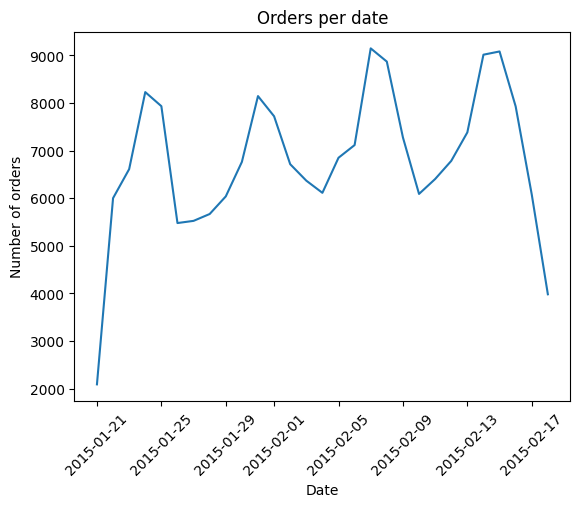

In [90]:
plt.plot(df_date_orders.date, df_date_orders.order_id)
plt.title('Orders per date')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Number of orders')
plt.show()

There's a weekly seasonal trend in the data. Sales are slowly increasing over time.

### What day of the week do the clients order more?

In [91]:
df_weekdays_orders = df.groupby('weekday')['order_id'].count().reset_index().sort_values('weekday')
df_weekdays_orders

,weekday,order_id
0,0,27401
1,1,24061
2,2,24253
3,3,25673
4,4,27874
5,5,34541
6,6,33611


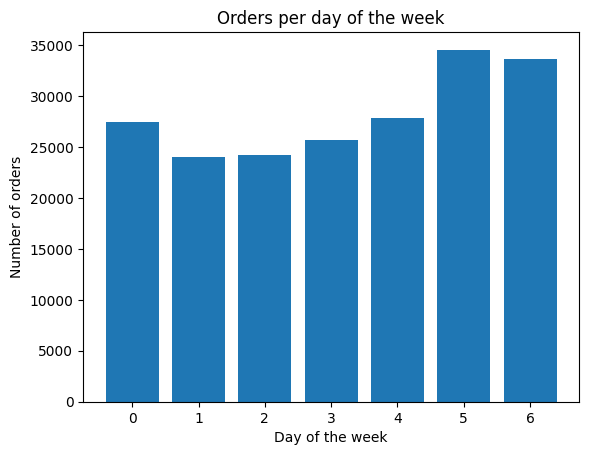

In [92]:
plt.bar(df_weekdays_orders.weekday, df_weekdays_orders.order_id)
plt.title('Orders per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Number of orders')
plt.show()

Friday (5) and Saturday (6) are the two days with more orders made by consumers with over 30.000 orders, followed by Thursay (4) and Sunday (0).

Monday (1) and Tuesday (2) are the days with less demand of food delivery.

### And at what hours?

In [93]:
df_hours_orders = df.groupby('hour')['order_id'].count().reset_index().sort_values('hour')
df_hours_orders

,hour,order_id
0,0,12668
1,1,28187
2,2,36972
3,3,27067
4,4,15250
5,5,7095
6,6,1416
7,7,11
8,8,1
9,14,40


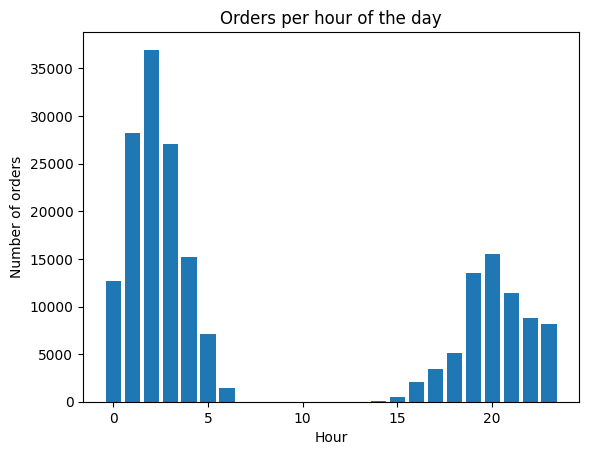

In [94]:
plt.bar(df_hours_orders.hour, df_hours_orders.order_id)
plt.title('Orders per hour of the day')
plt.xlabel('Hour')
plt.ylabel('Number of orders')
plt.show()

Most deliveries are made after midnight, peaking at around 1 and 3 h in the morning.

During the evening and night, the orders usually start pearking around 19 and 21 h.

From 7 h to 14 h the delivery service remains closed.

### In which markets are clients making more delivery orders?

In [95]:
df_markets_orders = df.groupby('market_id')['order_id'].count().reset_index().sort_values('market_id')
df_markets_orders

,market_id,order_id
0,1.0,38165
1,2.0,55314
2,3.0,23408
3,4.0,47985
4,5.0,18052
5,6.0,14490


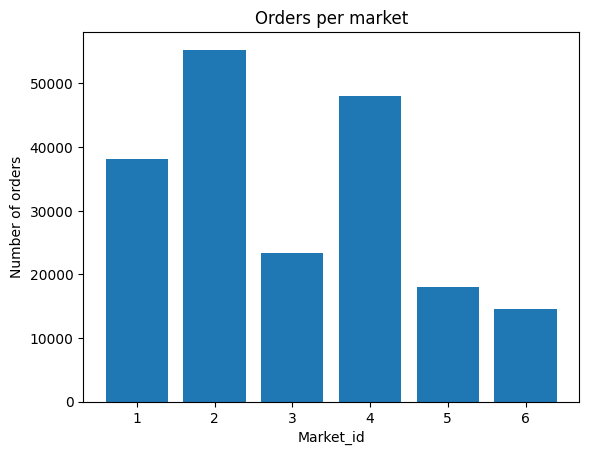

In [96]:
plt.bar(df_markets_orders.market_id, df_markets_orders.order_id)
plt.title('Orders per market')
plt.xlabel('Market_id')
plt.ylabel('Number of orders')
plt.show()

In markets 2 and 4 more delivery orders are made, especially compared to markets 6, 5 and 3.

### Which are the top 10 restaurants?

In [97]:
df_store_orders = df.groupby('store_id')['order_id'].count().reset_index()\
    .sort_values('order_id', ascending = False).head(10)
df_store_orders['store_id'] = df_store_orders['store_id'].astype('string')
df_store_orders

,store_id,order_id
6619,6865,937
1262,1311,863
302,314,814
1621,1686,765
3791,3937,721
6671,6917,668
5853,6074,632
4204,4367,593
3607,3748,560
6270,6503,547


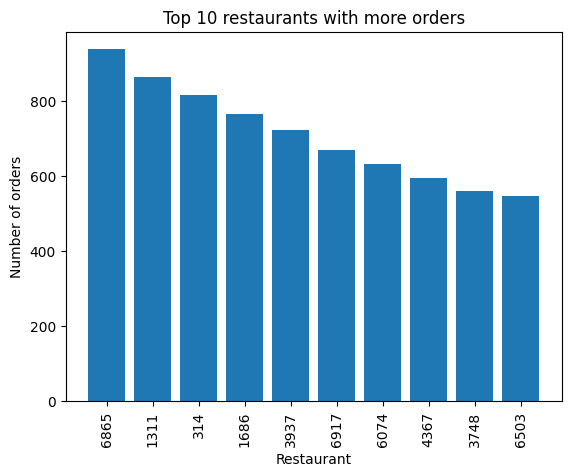

In [98]:
plt.bar(df_store_orders.store_id, df_store_orders.order_id)
plt.title('Top 10 restaurants with more orders')
plt.xlabel('Restaurant')
plt.xticks(rotation=90)
plt.ylabel('Number of orders')
plt.show()

### Category

In [99]:
df_category_orders = df.groupby('store_primary_category')['order_id'].count().reset_index()\
    .sort_values('order_id', ascending = False).head(15)
df_category_orders

,store_primary_category,order_id
4,american,20025
56,pizza,17614
47,mexican,17315
13,burger,11318
59,sandwich,10287
20,chinese,9504
40,japanese,9421
24,dessert,9080
28,fast,7549
36,indian,7440


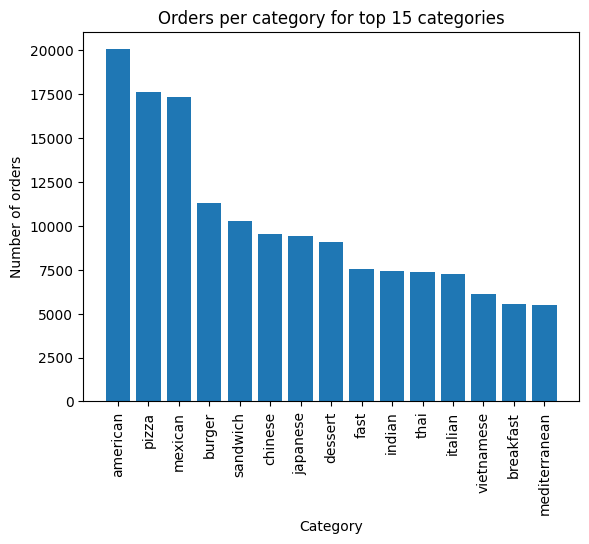

In [100]:
plt.bar(df_category_orders.store_primary_category, df_category_orders.order_id)
plt.title('Orders per category for top 15 categories')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.ylabel('Number of orders')
plt.show()

The most popular restaurants for delivery are american, italian (pizza) or mexican in the U.S.

## 3.2. Items exploration

### What is the distribution of the number of items ordered?

In [101]:
df_items_orders = df.groupby('total_items')['order_id'].count().reset_index().sort_values('total_items')
df_items_orders.head(10)

,total_items,order_id
0,1,40617
1,2,55132
2,3,39248
3,4,25136
4,5,14054
5,6,8618
6,7,5023
7,8,3050
8,9,1860
9,10,1284


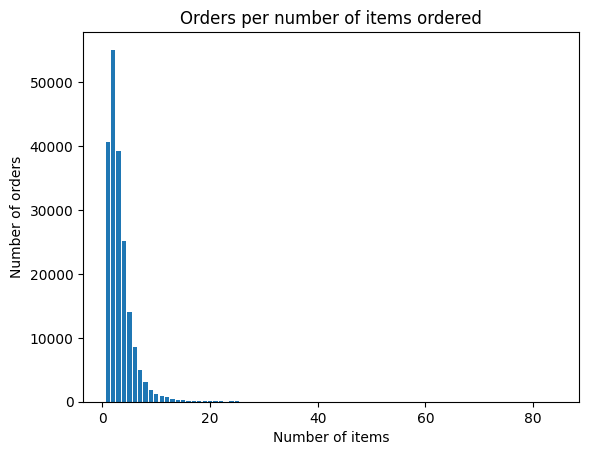

In [102]:
plt.bar(df_items_orders.total_items, df_items_orders.order_id)
plt.title('Orders per number of items ordered')
plt.xlabel('Number of items')
plt.ylabel('Number of orders')
plt.show()

Consumers usually order between 1 and 5 items.

### How many distinct items are ordered usually?

In [103]:
df_distinct_items_orders = df.groupby('num_distinct_items')['order_id'].count().reset_index().sort_values('num_distinct_items')
df_distinct_items_orders.head(10)

,num_distinct_items,order_id
0,1,49837
1,2,59171
2,3,41837
3,4,23184
4,5,11771
5,6,5695
6,7,2917
7,8,1419
8,9,734
9,10,389


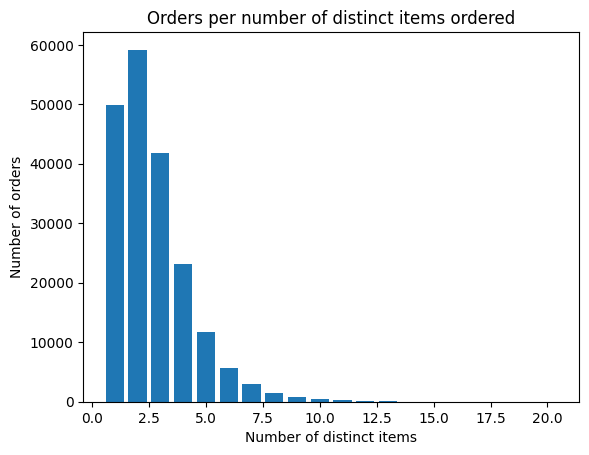

In [104]:
plt.bar(df_distinct_items_orders.num_distinct_items, df_distinct_items_orders.order_id)
plt.title('Orders per number of distinct items ordered')
plt.xlabel('Number of distinct items')
plt.ylabel('Number of orders')
plt.show()

The most common number of distintct items are between 1 and 3. An order with 10 or more different items is very rare.

## 3.3. Delivery duration exploration

In [105]:
df.columns

Index(['store_id', 'market_id', 'order_id', 'created_at',
       'actual_delivery_time', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'delivery_duration',
       'month', 'day', 'weekday', 'hour', 'date', 'busy_dashers_ratio',
       'store_primary_category'],
      dtype='object')

### What is the distribution of the delivery duration?

In [106]:
df['delivery_duration'].describe()

count    197414.000000
mean       2861.586012
std        1164.097113
min         101.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       57032.000000
Name: delivery_duration, dtype: float64

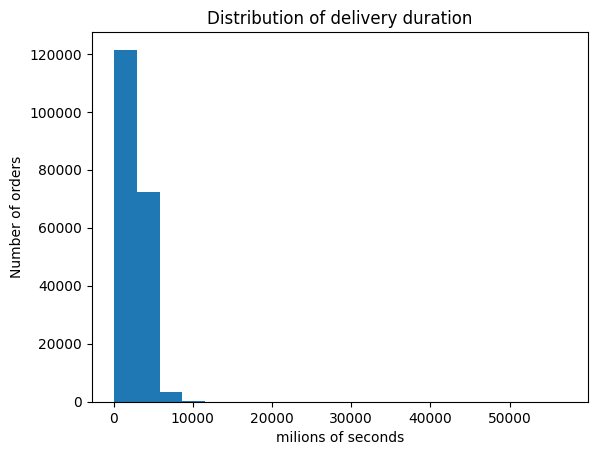

In [107]:
plt.hist(df.delivery_duration, bins = 20)
plt.title('Distribution of delivery duration')
plt.ylabel('Number of orders')
plt.xlabel('milions of seconds')
plt.show()

The average delivery duration is around 47 minutes and the median is 44 minutes. The minimum delivery duration is slightly over a minute and a half, whole the maximum duration is over 15 hours.

The distribution is skewed (asymetric) towards the right. 

Conclusions:

- It is more common that the delivery duration is above the median than below it. 

- It is harder to deliver faster than taking longer. Many things can happen to slow down the delivery: delay on the kitchen, traffic on the road...

### What is the average delivery duration per day of the week?

In [108]:
df_weekdays_delivery = df.groupby('weekday').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index().sort_values('weekday')
df_weekdays_delivery

,weekday,delivery_duration,order_id
0,0,3090.760739,27401
1,1,2779.843731,24061
2,2,2652.959840,24253
3,3,2826.104624,25673
4,4,2684.757803,27874
5,5,3005.173128,34541
6,6,2909.998007,33611


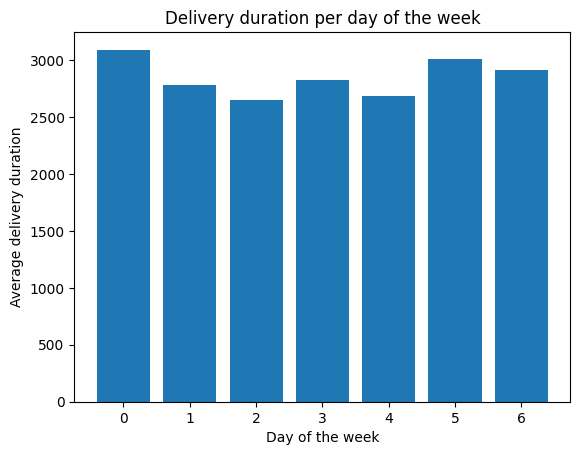

In [109]:
plt.bar(df_weekdays_delivery.weekday, df_weekdays_delivery.delivery_duration)
plt.title('Delivery duration per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average delivery duration')
plt.show()

On Sundays the average delivery time is slightly higher.

There is not a big difference in delivery duration per day of the week.

### And per hours?

In [110]:
df_hours_delivery = df.groupby('hour').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index().sort_values('hour')\
    .query('order_id > 50')
df_hours_delivery

,hour,delivery_duration,order_id
0,0,2647.986896,12668
1,1,2936.328627,28187
2,2,3290.271719,36972
3,3,3154.117228,27067
4,4,2676.364918,15250
5,5,2402.817054,7095
6,6,2444.800141,1416
10,15,3183.336431,538
11,16,2862.302513,2109
12,17,2654.777615,3413


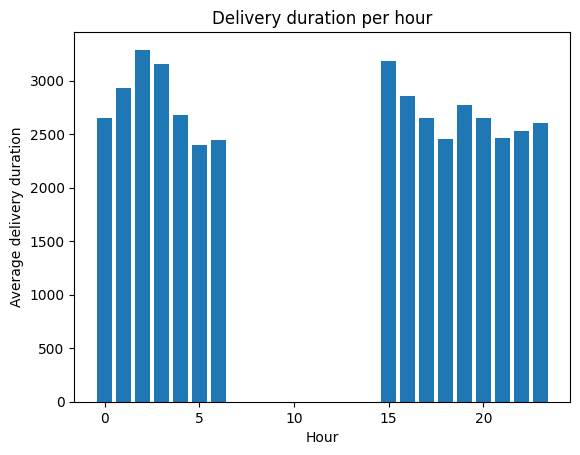

In [111]:
plt.bar(df_hours_delivery['hour'], df_hours_delivery.delivery_duration)
plt.title('Delivery duration per hour')
plt.xlabel('Hour')
plt.ylabel('Average delivery duration')
plt.show()

The delivery duration for orders at peak hours at midnight (between 1 and 3 am) is higher than the average. The same is true for the orders made at 15 h, when the service resumes.

### In what markets the delivery duration is higher and lower?

In [112]:
df_markets_delivery = df.groupby('market_id').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('market_id')
df_markets_delivery

,market_id,delivery_duration,order_id
0,1.0,3092.429556,38165
1,2.0,2759.681238,55314
2,3.0,2858.213602,23408
3,4.0,2833.865875,47985
4,5.0,2787.928928,18052
5,6.0,2831.590614,14490


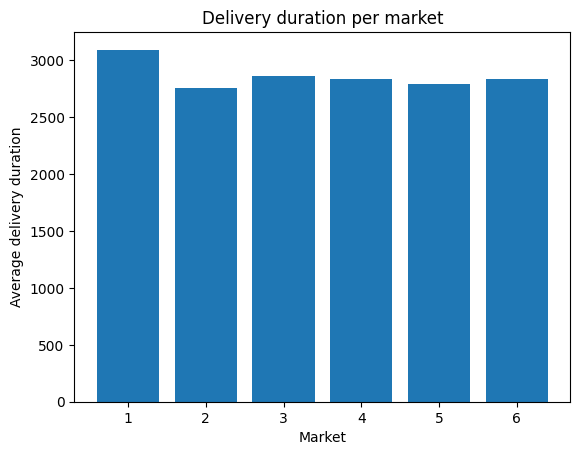

In [113]:
plt.bar(df_markets_delivery['market_id'], df_markets_delivery.delivery_duration)
plt.title('Delivery duration per market')
plt.xlabel('Market')
plt.ylabel('Average delivery duration')
plt.show()

At market 1 the average delivery duration is higher than the other 5 markets.

### And in which restaurants?

In [114]:
df_stores_delivery = df.groupby('store_id').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('delivery_duration', ascending = False).query('order_id > 50').head(10)
df_stores_delivery['store_id'] = df_stores_delivery['store_id'].astype('string')
df_stores_delivery

,store_id,delivery_duration,order_id
4140,4301,4808.250000,52
1329,1378,4794.949495,99
385,400,4593.530435,115
3308,3438,4565.410714,168
2232,2319,4237.850000,60
1978,2049,4223.322581,62
5838,6056,4183.630137,146
4814,4998,4101.941799,189
4070,4229,4076.708738,103
1332,1381,4052.367347,147


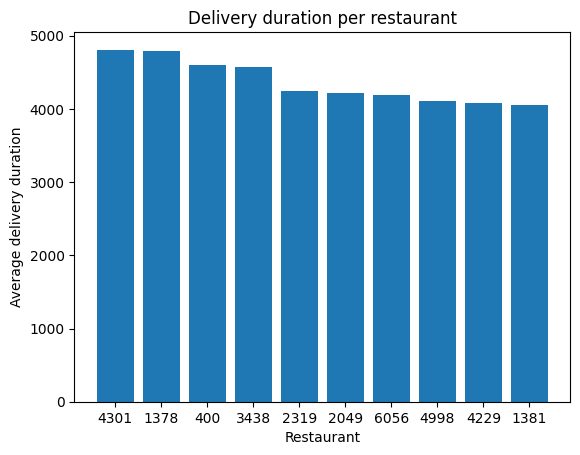

In [115]:
plt.bar(df_stores_delivery['store_id'], df_stores_delivery.delivery_duration)
plt.title('Delivery duration per restaurant')
plt.xlabel('Restaurant')
plt.ylabel('Average delivery duration')
plt.show()

### Does the number of items affect the delivery duration?

In [116]:
df_items_delivery = df.groupby('total_items').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('total_items').query('order_id > 20')
df_items_delivery

,total_items,delivery_duration,order_id
0,1,2679.608637,40617
1,2,2775.720580,55132
2,3,2872.599394,39248
3,4,2951.158617,25136
4,5,3014.459300,14054
5,6,3082.011720,8618
6,7,3152.271551,5023
7,8,3201.393770,3050
8,9,3264.402151,1860
9,10,3339.775701,1284


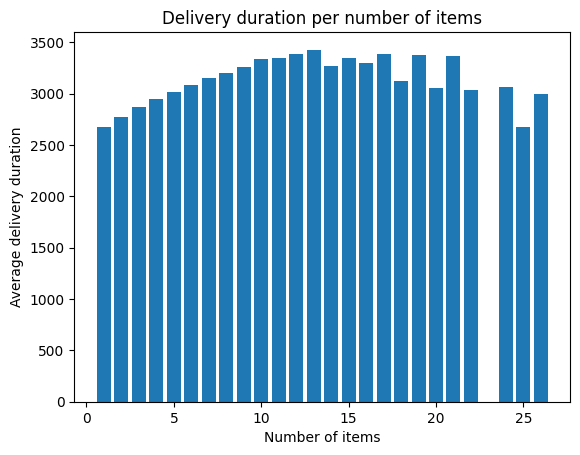

In [117]:
plt.bar(df_items_delivery['total_items'], df_items_delivery.delivery_duration)
plt.title('Delivery duration per number of items')
plt.xlabel('Number of items')
plt.ylabel('Average delivery duration')
plt.show()

The delivery duration increases when the amount of items ordered is higher.

### And the uniqueness of the items?

In [118]:
df_unique_items_delivery = df.groupby('num_distinct_items').agg({'delivery_duration' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('num_distinct_items').query('order_id > 20')
df_unique_items_delivery

,num_distinct_items,delivery_duration,order_id
0,1,2696.485282,49837
1,2,2788.798499,59171
2,3,2880.628678,41837
3,4,3009.094030,23184
4,5,3095.307451,11771
5,6,3229.524495,5695
6,7,3315.313336,2917
7,8,3398.911910,1419
8,9,3583.918256,734
9,10,3696.892031,389


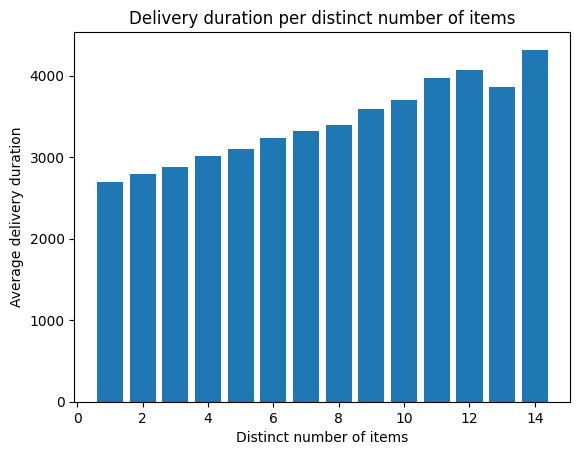

In [119]:
plt.bar(df_unique_items_delivery['num_distinct_items'], df_unique_items_delivery.delivery_duration)
plt.title('Delivery duration per distinct number of items')
plt.xlabel('Distinct number of items')
plt.ylabel('Average delivery duration')
plt.show()

The delivery duration clearly increases when the distinct number of items ordered is higher.

## 3.4. Dashers exploration

### At what hours are there more working dashers?

In [120]:
df_onshift_hours = df.groupby('hour').agg({'total_onshift_dashers' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('hour').query('order_id > 50')
df_onshift_hours

,hour,total_onshift_dashers,order_id
0,0,27.933153,12668
1,1,54.324956,28187
2,2,67.991014,36972
3,3,64.205752,27067
4,4,44.996552,15250
5,5,23.589613,7095
6,6,13.421094,1416
10,15,2.141473,538
11,16,4.965949,2109
12,17,7.757729,3413


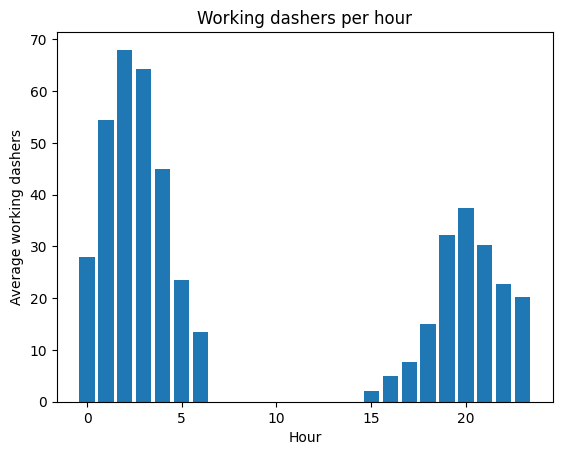

In [121]:
plt.bar(df_onshift_hours.hour, df_onshift_hours.total_onshift_dashers)
plt.title('Working dashers per hour')
plt.xlabel('Hour')
plt.ylabel('Average working dashers')
plt.show()

### During which days are there more working dashers?

In [122]:
df_onshift_weekday = df.groupby('weekday').agg({'total_onshift_dashers' : 'mean', 'order_id' : 'count'}).reset_index()\
    .sort_values('weekday')
df_onshift_weekday

,weekday,total_onshift_dashers,order_id
0,0,42.082683,27401
1,1,37.334706,24061
2,2,40.069545,24253
3,3,43.746672,25673
4,4,48.603385,27874
5,5,52.112138,34541
6,6,45.938278,33611


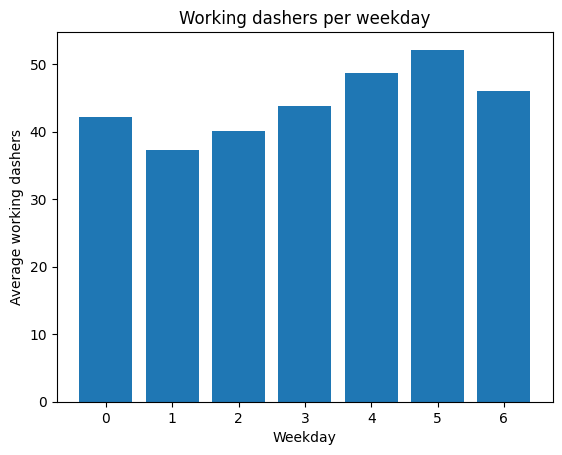

In [123]:
plt.bar(df_onshift_weekday.weekday, df_onshift_weekday.total_onshift_dashers)
plt.title('Working dashers per weekday')
plt.xlabel('Weekday')
plt.ylabel('Average working dashers')
plt.show()

There are more working dashers on weekends, as it was expected since these days the number of orders is higher.

### How related is the delivery duration to the busy dashers ratio?

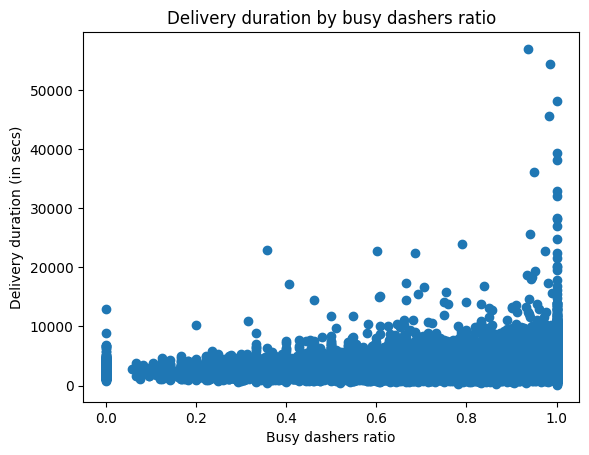

In [124]:
plt.scatter(df['busy_dashers_ratio'], df['delivery_duration'])
plt.title('Delivery duration by busy dashers ratio')
plt.xlabel('Busy dashers ratio')
plt.ylabel('Delivery duration (in secs)')
plt.show()

When the ratio is close to 1, the delivery duration increases.

## 3.5. Conclusions

- Friday and Saturday are the days with more orders made by consumers, while Monday, Tuesday and Wednesday less orders are made.

- Most orders are made around 1 and 3 am. In the evening there aren't that many delivery orders.

- Markets 2 and 4 generate more orders.

- American food, Pizza and Mexican food are consumers' favourite categories.

- Most clients order between 1 and 5 items.

- The average delivery duration is 2861.59 seconds, or 47 minutes and 42 seconds.

- On Sunday, the average delivery duration is the highest with 3090.76 seconds, or 51 minutes and 31 seconds.

- At 3, 4 and 15 h the average delivery duration is also over 3000 seconds (over 50 minutes).

- In market 1 the delivery duration is higher compared to the other markets.

- There are restaurants with a delivery duration of over 4000 seconds, like the stores: 4301, 1378, 400, 3438 & 2319.

- The amount of items and the number of unique items ordered affects the delivery duration, as the preparation time increases.

# 4. Saving clean data

The df with the data cleaned and prepared will be saved into a csv file in the downloads folder for Project 4 - Data modeling with Python.

Note: remember to change "Roger" for your profile name in your computer.

In [125]:
df.to_csv("C:/Users/Roger/Downloads/historical_data_clean.csv", index = False)